# Mercari price Suggestion Challenge

## Challenge Overview

 In this competition, you will predict the sale price of a listing based on information a user provides for this listing. 

## Challenge Description:

 Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices.

<h2> Real world/Business Objectives and constraints  </h2>

Objectives:
1. Predict the price of an item given its condition, decsription and other related features.
2. Minimize the difference between predicted and actual price (RMSLE)


<h1>  Machine Learning Problem </h1>

<h2> Data </h2>

<h3> Data Overview </h3>

<p> Get the data from : https://www.kaggle.com/c/mercari-price-suggestion-challenge/data </p>
<p> Data files : 
<ul> 
<li> train.tsv </li>
<li> test_stg2.tsv </li>

</ul>
<pre>  All these are tab-seperated files

<h2> Mapping the real world problem to a Machine Learning Problem </h2>

<h3>  Type of Machine Learning Problem </h3>

<pre>
For a given item, we need to suggest the price of that item given its different features like category, name, brand name, item description etc. 
The given problem is a Regression problem 
</pre>

### Type of problem: Regression

### Error metric: RMSLE (Root Mean Square Logarithmic Error)

<h3>  Machine Learning Objective and Constraints </h3>

1. Minimize RMSLE.
2. Try to provide some interpretability.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
#from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
from wordcloud import WordCloud
import nltk
from tqdm import tqdm
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1ZO0pAlj8aFx3UKMTRe_QJ1xX13SE0Ehu'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.tsv') 

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1B0Qv9N997evCqc6upAKNa-qD7XDlw-Ml'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test.tsv') 

# Step 1: Reading Raw Data 

In [32]:
data = pd.read_csv('train.tsv', sep='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [33]:
train= data.copy()
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
print("The columns in data are as follows:")
train.dtypes

The columns in data are as follows:


train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [7]:
#Describe the dataset
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


## Loading the test file

In [151]:
data = pd.read_csv('test_stg2.tsv', sep='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (3460725, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [152]:
test2= data.copy()
test2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [153]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
test_id              int64
name                 object
item_condition_id    int64
category_name        object
brand_name           object
shipping             int64
item_description     object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


## Checking for null values in data

In [8]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [116]:
test2.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name            True
shipping             False
item_description      True
dtype: bool

In [117]:
submission_final= pd.DataFrame(test2['test_id'])
submission_final.head(5)

,test_id
0,0
1,1
2,2
3,3
4,4


### Observation
Category_name, brand_name and item_description have null values. So we are processing this coulumns   

In [35]:
def fill_missing_data(data):
    data.category_name.fillna(value = "Others", inplace = True)
    data.brand_name.fillna(value = "Not known", inplace = True)
    data.item_description.fillna(value = "No description given", inplace = True)
    return data

In [36]:
train = fill_missing_data(train)
#df=df.dropna()
print(np.shape(train))
train.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not known,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not known,44.0,0,Complete with certificate of authenticity


In [118]:
test2 = fill_missing_data(test2)
#df=df.dropna()
print(np.shape(test2))
test2.head()

(3460725, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Not known,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Not known,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Not known,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Not known,1,Rediscovering life after the loss of a loved o...


In [15]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
dtype: bool

In [119]:
test2.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
dtype: bool

## Univariate Data Analysis

<h3>1. Price</h3>

In [11]:
#description of price
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

The maximum price of an item is 2009 whereas minimum price is 0 (approx.).

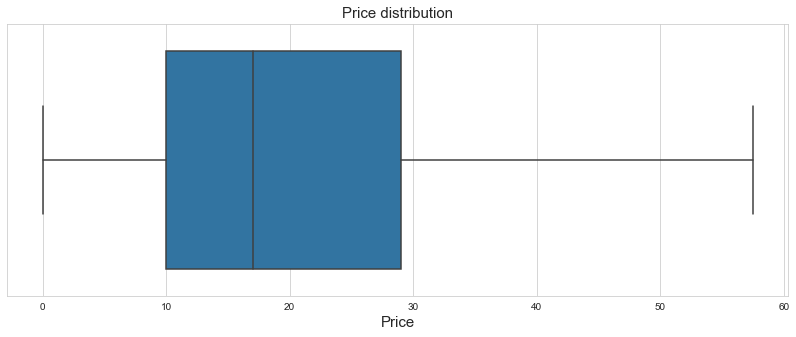

In [12]:
#Box-plot
fig, ax = plt.subplots(figsize=(14,5))
plt.title('Price distribution', fontsize=15)
sns.boxplot(train.price,showfliers=False)
ax.set_xlabel('Price',fontsize=15)

plt.show()

We can see most of the items have the price value between 25-28.And all the items have their price listings between 10-28

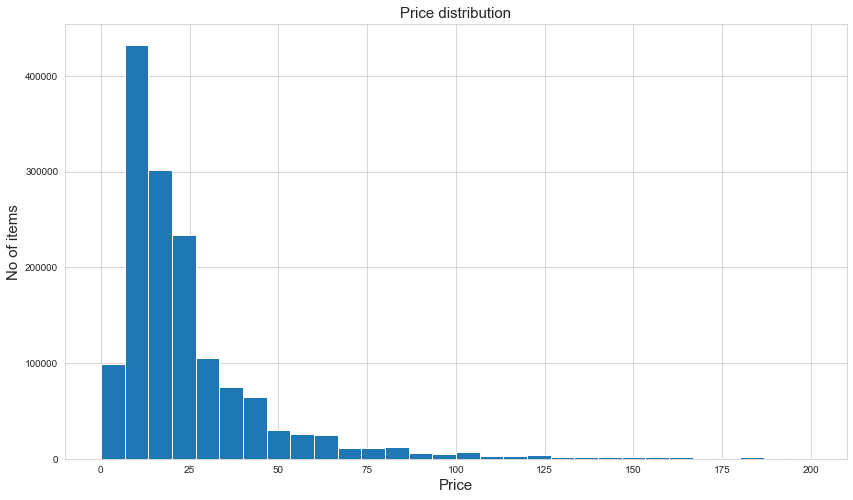

In [13]:
#Histogram
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(train.price,bins=30,range=[0,200],label="Price")
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('Price',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)

plt.show()

Histogram gives a better representation than box-plot. It reveals most of the items have their prices between 15-22. 

In [14]:
#We will add log(price) as a column in our train data
train["logPrice"] = np.log(train["price"]+1)

In [15]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,logPrice
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,10.0,1,No description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not known,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not known,44.0,0,Complete with certificate of authenticity,3.806662


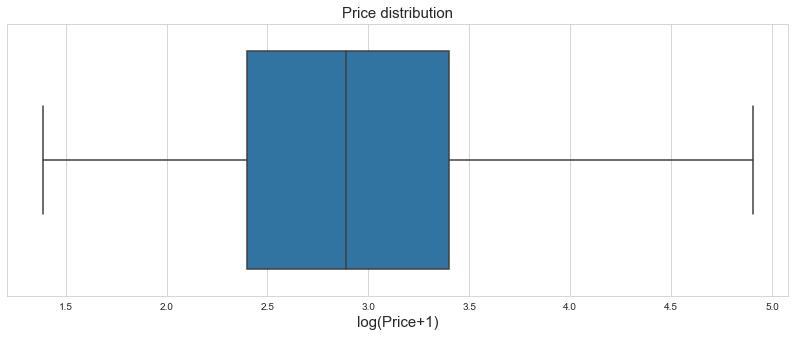

In [16]:
#Box-plot using log(price+1)
fig, ax = plt.subplots(figsize=(14,5))
plt.title('Price distribution', fontsize=15)
sns.boxplot(train.logPrice,showfliers=False)
ax.set_xlabel('log(Price+1)',fontsize=15)

plt.show()

We have scaled down our 'price' feature logprice. We have added log(Price+1) to it as log(0) is undefined. hence if price for an item is 0, then the item will have no price as defined. 

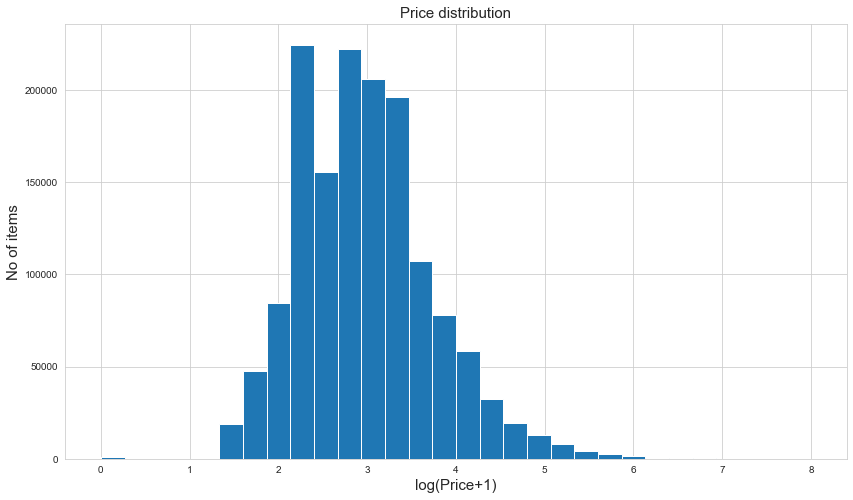

In [17]:
#Histogram using log(price+1)
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(train.logPrice,bins=30,range=[0,8],label="Price")
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('log(Price+1)',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)

plt.show()

The 'log(price+1)' feature has the price range spread over 2.3-3.5 for most of the items

<h3>2. Shipping</h3> 

In [18]:
print("0: shipping charges paid by seller")
print("1: shipping charges paid by buyers")
print("COUNT:\n",train['shipping'].value_counts())
print("Fraction:\n",train['shipping'].value_counts(normalize=True))

0: shipping charges paid by seller
1: shipping charges paid by buyers
COUNT:
 0    819435
1    663100
Name: shipping, dtype: int64
Fraction:
 0    0.552726
1    0.447274
Name: shipping, dtype: float64


In [19]:
seller_charged = []
buyer_charged = []
for i in tqdm(range(0,len(train['shipping']))):
    if train['shipping'][i]==0:
        seller_charged.append(train['logPrice'][i])
    else:
        buyer_charged.append(train['logPrice'][i])

100%|█████████████████████████████████████████████████████████████████████| 1482535/1482535 [02:21<00:00, 10453.70it/s]


In [20]:
print(len(seller_charged))
print(len(buyer_charged))

819435
663100


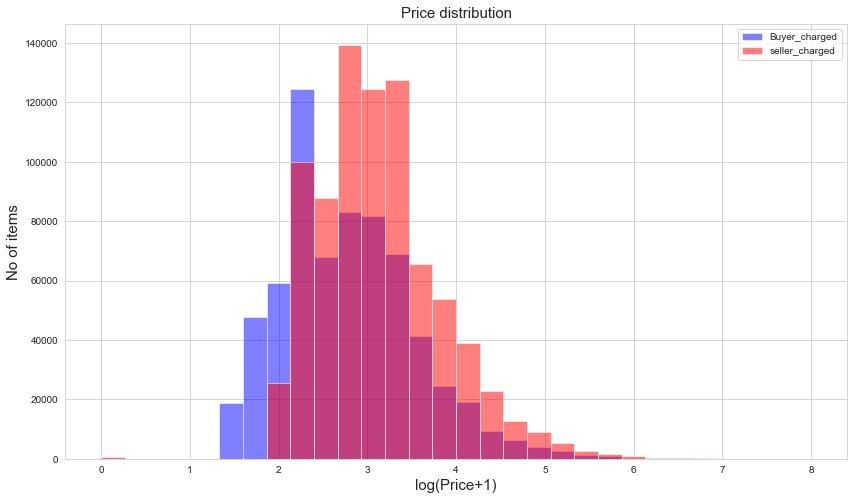

In [21]:
#Ref: https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#Ref: https://stackoverflow.com/questions/28398200/matplotlib-plotting-transparent-histogram-with-non-transparent-edge
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(buyer_charged,bins=30,range=[0,8],label="Buyer_charged",color='b',alpha=0.5)
ax.hist(seller_charged,bins=30,range=[0,8],label="seller_charged",color='r',alpha=0.5)
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('log(Price+1)',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)
plt.legend(loc='upper right')

plt.show()

Here, we can see that for items which have lesser price, the shipping had to be paid by the buyer for profit reasons. Also, as the price increases, we can see that the shipping charges have been paid by the seller.. And there is a lot of overlap for items where both buyer and seller have been charged.

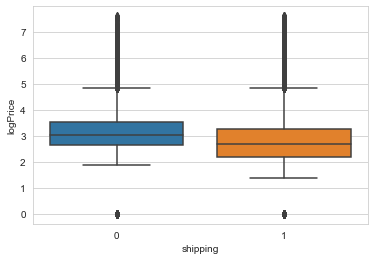

In [22]:
#Boxplot shipping vs logPrice
sns.boxplot(x=train.shipping,y=train.logPrice,orient='v') 

Similar to our conclusions from the histogram plot, boxplot also reveals that when price increases, the seller is charged and vice-versa. 

<h3>3. Item category</h3>

In [37]:
#Ref: https://stackoverflow.com/questions/12282232/how-do-i-count-unique-values-inside-a-list
print("No of unique values in item category is:",train['category_name'].nunique())

No of unique values in item category is: 1288


In [38]:
print("Top-10 unique category by frequency:\n\n",train['category_name'].value_counts()[:10])

Top-10 unique category by frequency:

 Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64


In [39]:
# 1. Extract 3 category related features 
def cat_split(row):
    try:
        text = row
        text1, text2, text3 = text.split('/')
        return text1, text2, text3
    except:
        return ("Label not given", "Label not given", "Label not given")

In [40]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: cat_split(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not known,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not known,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [120]:
test2['general_cat'], test2['subcat_1'], test2['subcat_2'] = \
zip(*test2['category_name'].apply(lambda x: cat_split(x)))
test2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Not known,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Not known,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Not known,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Not known,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [41]:
print("No of unique values in main category: ",train['general_cat'].nunique())
print("No of unique values in Sub_category1: ",train['subcat_1'].nunique())
print("No of unique values in Sub_category2: ",train['subcat_2'].nunique())

No of unique values in main category:  11
No of unique values in Sub_category1:  114
No of unique values in Sub_category2:  865


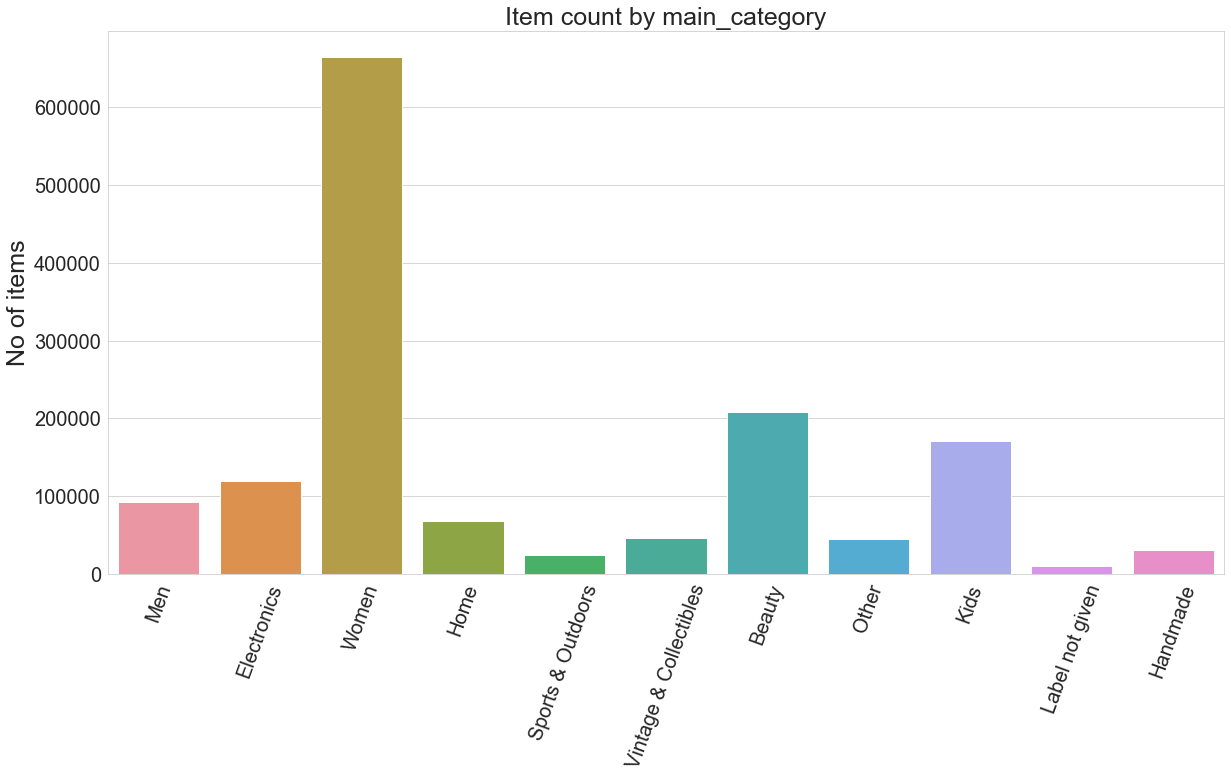

In [28]:
#Ref: https://seaborn.pydata.org/generated/seaborn.countplot.html
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='general_cat', data=train, ax=ax)
plt.title('Item count by main_category',fontsize=25)
plt.ylabel('No of items',fontsize=25)
plt.xlabel('')
plt.xticks(rotation=70,fontsize=20)
plt.yticks(fontsize=20)

plt.show()

From this plot, we can conclude that items of women has the maximum number in main category. 

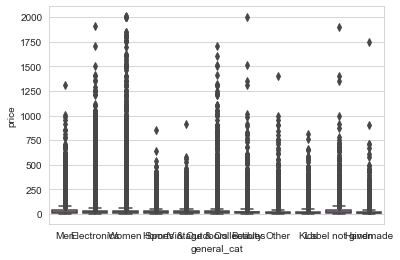

In [29]:
#Ref: http://www.datasciencemadesimple.com/box-plot-in-python/
sns.boxplot(x=train.general_cat,y=train.price,orient='v')

Top-10 subcategory_1:


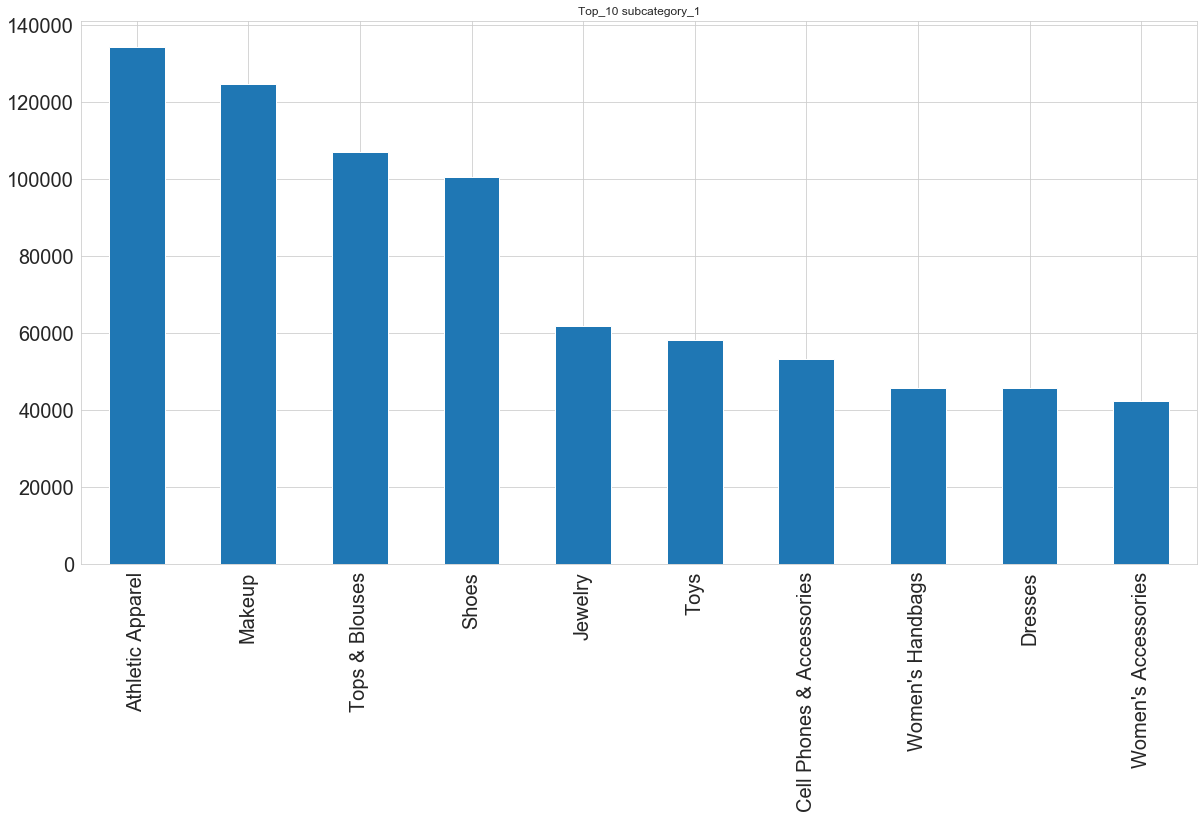

In [42]:
#Ref: https://stackoverflow.com/questions/48799185/plot-histogram-matplotlib-with-labels-on-x-axis-instead-of-count
print("Top-10 subcategory_1:")
train.subcat_1.value_counts()[:10].plot(kind = 'bar',figsize = (20,10), title="Top_10 subcategory_1",fontsize=20)

Here, it lists the top 10 items with greatest frequencies in sub-category 1. 

Top-10 subcategory_2:


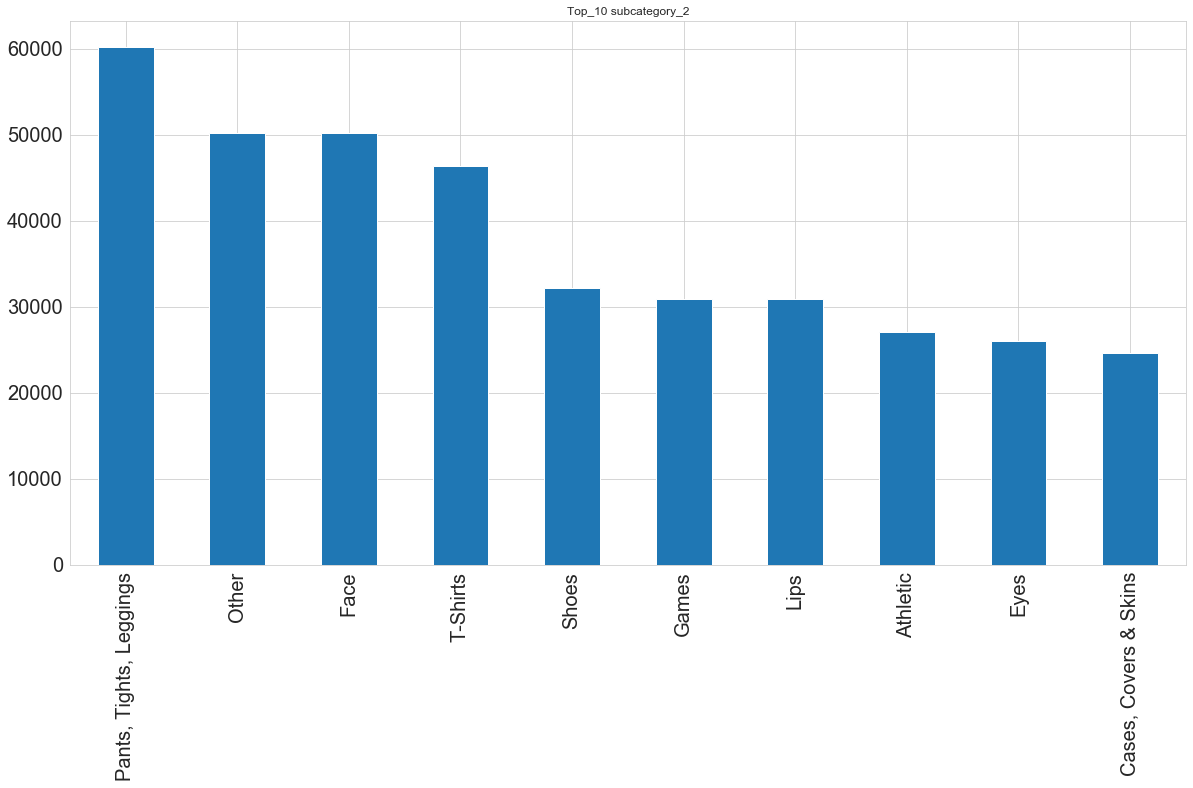

In [43]:
#Ref: https://stackoverflow.com/questions/48799185/plot-histogram-matplotlib-with-labels-on-x-axis-instead-of-count
print("Top-10 subcategory_2:")
train.subcat_2.value_counts()[:10].plot(kind = 'bar',figsize = (20,10), title="Top_10 subcategory_2",fontsize=20)

<h3>4. Brand name</h3>

In [32]:
print("No of unique brands: ",train['brand_name'].nunique())

No of unique brands:  4810


Top-10 brands by frequency of sale:


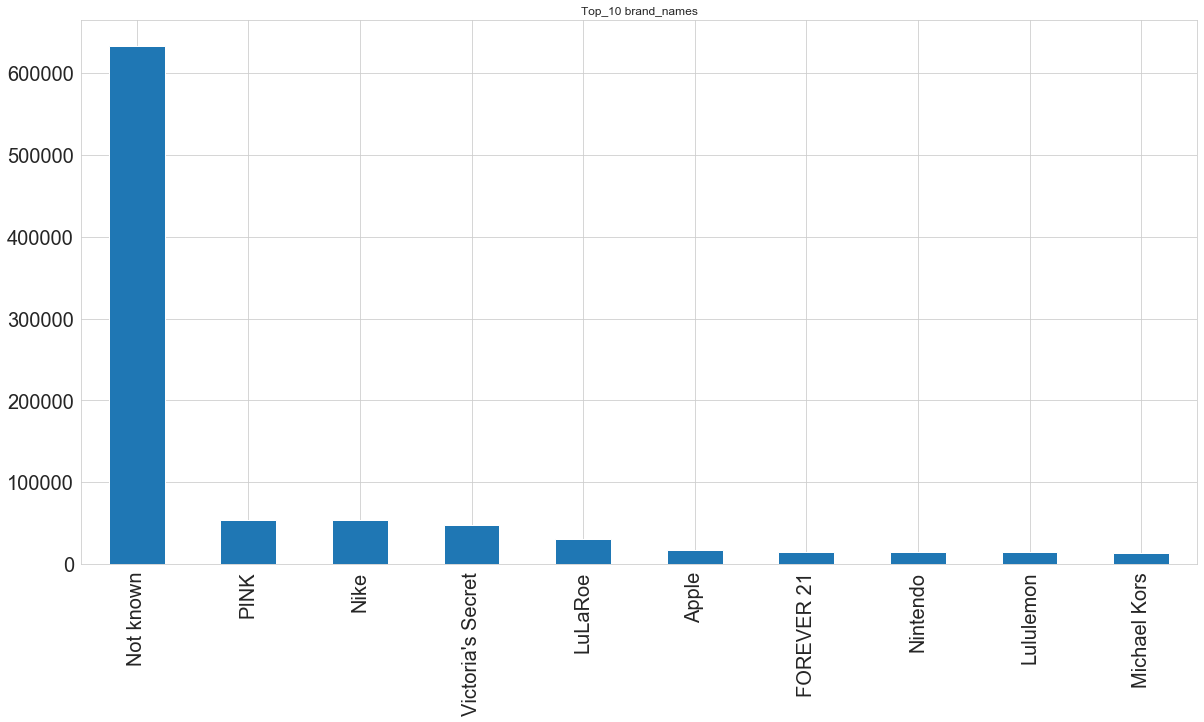

In [33]:
#Ref: https://stackoverflow.com/questions/48799185/plot-histogram-matplotlib-with-labels-on-x-axis-instead-of-count
print("Top-10 brands by frequency of sale:")
train.brand_name.value_counts()[:10].plot(kind = 'bar',figsize = (20,10), title="Top_10 brand_names",fontsize=20)

For most of the items, the brand name has not been listed can be deduced from the plot. Second to it, most number of items have 'Pink' and "Nike" as brand names.

<h3>5. Item description</h3>

In [34]:
def length(description):
    count = 0
    for i in description.split():
        count+=1
    return count

In [35]:
lol = []
for i in train['item_description']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    lol.append(temp)

print(lol[0])
print(len(lol))

['No description yet', 3]
1482535


In [36]:
mydf = pd.DataFrame(lol,columns=['desc','desc_length'])
print(mydf.head(2))

                                                desc  desc_length
0                                 No description yet            3
1  This keyboard is in great condition and works ...           36


In [37]:
train['description_len'] = mydf['desc_length']

In [38]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,logPrice,general_cat,subcat_1,subcat_2,description_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,3
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,36
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,29


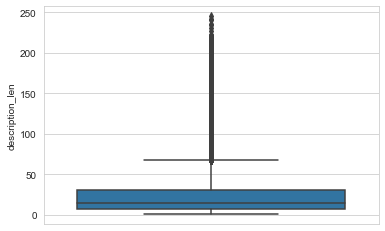

In [39]:
#Box-plot of description length
sns.boxplot(x=train.description_len,orient='v')

The box-plot of decsription length shows that most of the tiems have description length ranging between 15-40 words.

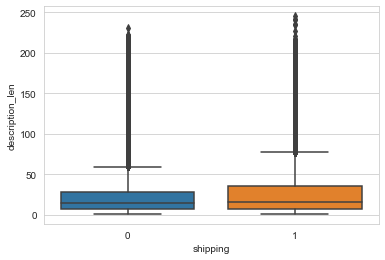

In [40]:
#Box-plot of description length
sns.boxplot(y=train.description_len,x=train.shipping,orient='v')

The description length vs shipping has been plotted. But it does't give much details about the underlying data. 

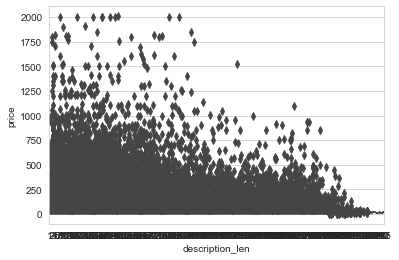

In [41]:
#Box-plot of description length with price
sns.boxplot(x=train.description_len,y=train.price,orient='v')

Here, description length vs price has been given. As length increases, price charged becomes less. Most of the items with lesser description length have more price value.

Top-10 item_descriptions by frequency:


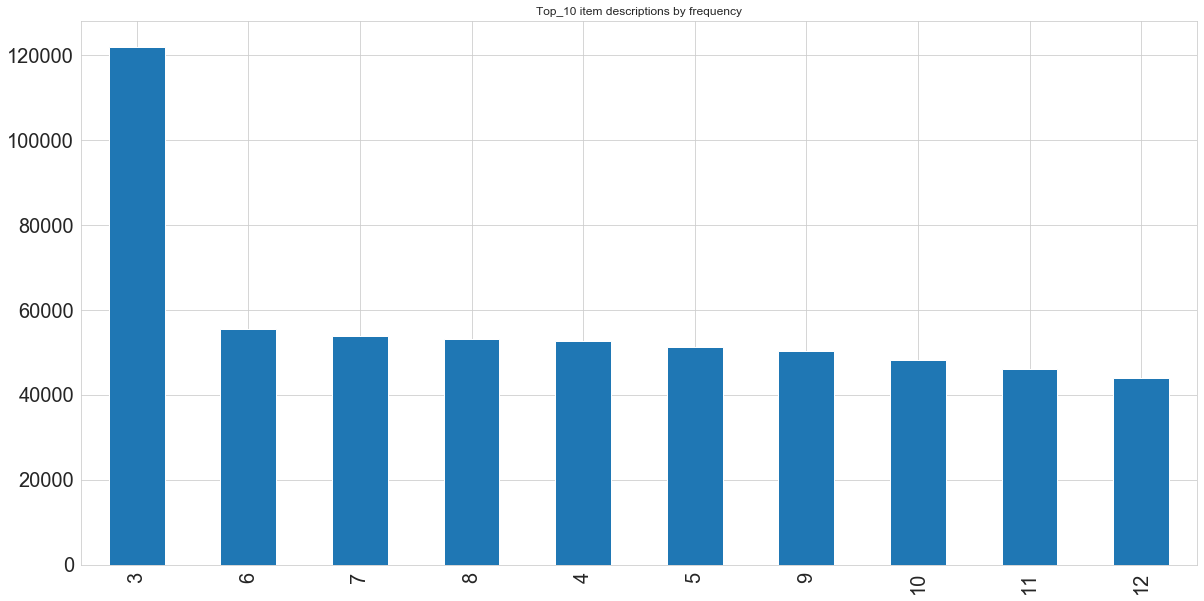

In [42]:
#Ref: https://stackoverflow.com/questions/48799185/plot-histogram-matplotlib-with-labels-on-x-axis-instead-of-count
print("Top-10 item_descriptions by frequency:")
train.description_len.value_counts()[:10].plot(kind = 'bar',figsize = (20,10),
                                               title="Top_10 item descriptions by frequency",fontsize=20)

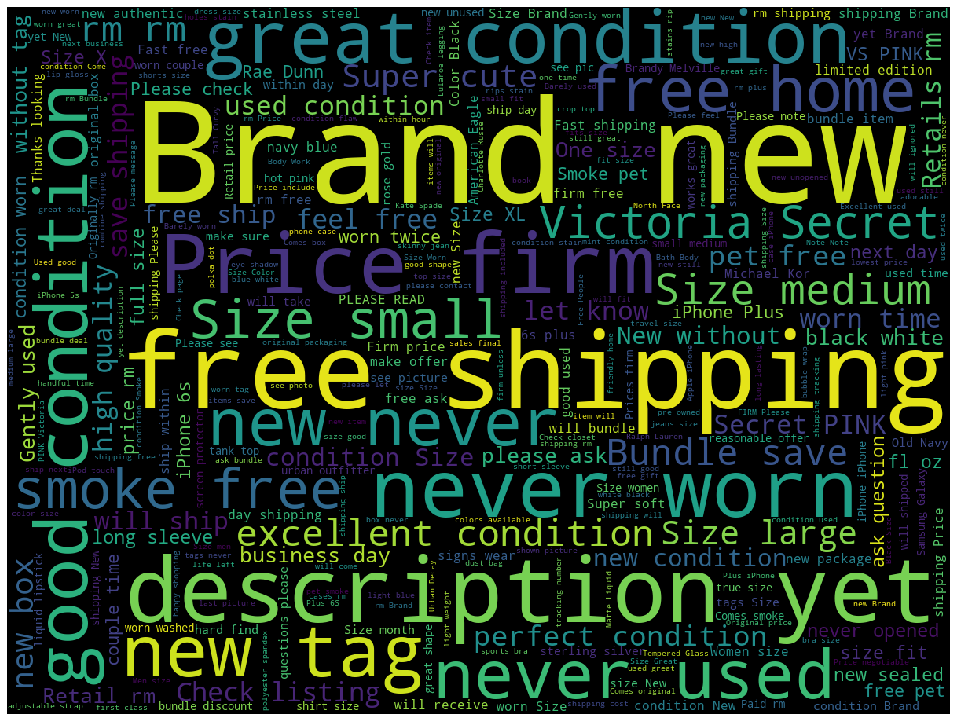

In [43]:
#Ref: https://www.kaggle.com/konohayui/mercari-price-suggestion-eda
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train.item_description.astype(str)))
plt.figure(figsize = (18, 13))
plt.imshow(wc)
plt.axis("off")
plt.show()

This word cloud plot gives a good idea about the words that appear frequently in the item description field.

## Basic Feature Engineering and Preprocessing

In [47]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [48]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

## Calculating sentiment score on item description as a feature

In [49]:
#for X_train
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_total_train = []
# tqdm is for printing the status bar
for sentance in tqdm(train['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_total_train.append(sent.lower().strip())

# after preprocesing
preprocessed_total_train[20000]

100%|██████████████████████████████████████████████████████████████████████| 1482535/1482535 [03:39<00:00, 6750.59it/s]


'minor flaws check pic condition bundle save'

In [52]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

train_sentiment = []; 
for sentence in tqdm(preprocessed_total_train):
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    train_sentiment.append(ss)

[nltk_data] Downloading package vader_lexicon to C:\Users\Kamal Sarkar
[nltk_data]     2001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████| 1482535/1482535 [11:24<00:00, 2166.64it/s]


In [53]:
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in train_sentiment:
    
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)

In [54]:
train['negative']=negative
train['neutral']=neutral
train['positive']=positive
train['compound']=compounding

## Calculating Correlation between different features

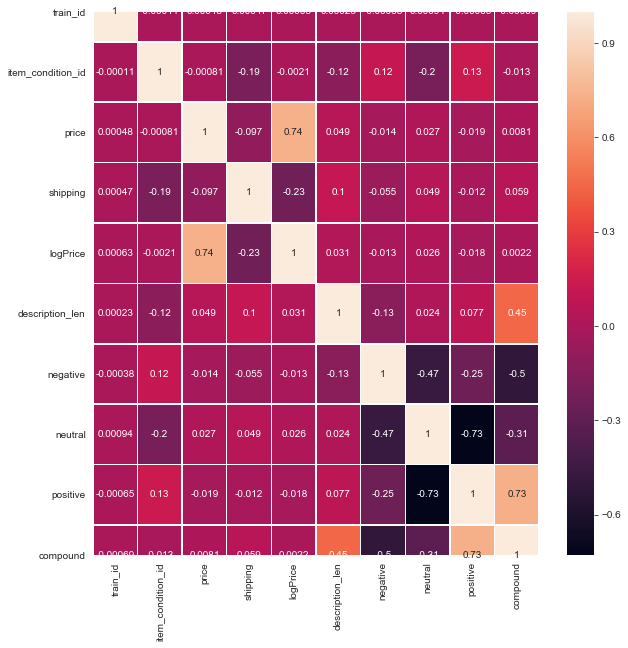

In [55]:
columns = list(train.columns)
plt.figure(figsize = (10, 10))
sns.heatmap(train[columns].corr(), annot = True, linewidth = 0.5)
plt.show()

#### 1. We can see that description length has a fair correleation with the price of an item. Hence, we will include this as an additional feature in the features list. 
#### 2. Also, features of sentiment score share some correlation with the target variable 'Price'. Hence we are including sentiment score on item description as an additional feature 


In [56]:
y_train = np.log(train["price"]+1)
train_ids = train['train_id'].values.astype(np.int32)
train.drop(['price', 'train_id','logPrice','description_len','negative', 'neutral','positive','compound'], axis=1, inplace=True)

In [58]:
train.head(5)

,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not known,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not known,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [ ]:
test_ids = test2['test_id'].values.astype(np.int32)
test2.drop(['test_id'], axis=1, inplace=True)

## Splitting the dataset into train and test

In [59]:
X=train 
y=y_train

In [60]:
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing on train and test datasets

In [42]:
#for X_train
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_train_des = []
# tqdm is for printing the status bar
for sentance in tqdm(df_train['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_train_des.append(sent.lower().strip())

# after preprocesing
preprocessed_train_des[20000]

100%|█████████████████████████████████████████████████████████████████████| 1186028/1186028 [01:36<00:00, 12343.74it/s]


'brand new received gift opened box thinking would keep decided stick two faced setting powder'

In [43]:
#for X_train
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_test_des = []
# tqdm is for printing the status bar
for sentance in tqdm(df_test['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_test_des.append(sent.lower().strip())

# after preprocesing
preprocessed_test_des[20000]

100%|███████████████████████████████████████████████████████████████████████| 296507/296507 [00:23<00:00, 12473.65it/s]


'three near mint erikas venusaur first edition holo'

In [44]:
#for X_train
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_test = []
# tqdm is for printing the status bar
for sentance in tqdm(test['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_test.append(sent.lower().strip())

# after preprocesing
preprocessed_test[20000]

100%|███████████████████████████████████████████████████████████████████████| 693359/693359 [00:54<00:00, 12768.51it/s]


'8 herbal essences gel'

In [122]:
#for X_train
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_test2 = []
# tqdm is for printing the status bar
for sentance in tqdm(test2['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_test2.append(sent.lower().strip())

# after preprocesing
preprocessed_test2[20000]

100%|█████████████████████████████████████████████████████████████████████| 3460725/3460725 [04:34<00:00, 12623.97it/s]


'8 herbal essences gel'

## Performing one-hot encoding on categorical features

## Name

In [45]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train['name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_name = vectorizer.transform(df_train['name'].values)
test_name = vectorizer.transform(df_test['name'].values)


print("After vectorizations")
print(train_name.shape)
print(test_name.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1186028, 15929)
(296507, 15929)
['00', '000', '001', '002', '003', '007', '007taz', '00g', '01', '02', '03', '04', '043', '045', '05', '06', '07', '08', '09', '0g', '0oz', '0r', '0s', '0x', '10', '100', '1000', '1001', '100ct', '100g', '100ml', '100pcs', '101', '102', '103', '104', '105', '106', '107', '108', '1080', '1080p', '109', '10c', '10ft', '10g', '10k', '10kt', '10lbs', '10m', '10ml', '10mm', '10oz', '10pairs', '10pc', '10pcs', '10pk', '10r', '10s', '10th', '10w', '10x', '10x13', '11', '110', '111', '112', '113', '114', '115', '11c', '11m', '11pc', '11r', '11s', '11w', '12', '120', '1200', '120gb', '122', '123', '1234', '124', '125', '127', '128', '128gb', '129', '12c', '12hr', '12k', '12m', '12mm', '12mo', '12month', '12months', '12oz', '12p', '12pc', '12pcs', '12r', '12s', '12th', '12v', '12w', '12x', '12x12', '12x15', '13', '130', '132', '135', '136', '13c', '13in', '13pc', '13s', '13th', '14', '140', '144', '1460', '149', '14g', '14k', '14kt', '14mm', 

In [123]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train['name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_name2 = vectorizer.transform(test2['name'].values)



print("After vectorizations")
print(submission_name2.shape)


print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(3460725, 15929)
['00', '000', '001', '002', '003', '007', '007taz', '00g', '01', '02', '03', '04', '043', '045', '05', '06', '07', '08', '09', '0g', '0oz', '0r', '0s', '0x', '10', '100', '1000', '1001', '100ct', '100g', '100ml', '100pcs', '101', '102', '103', '104', '105', '106', '107', '108', '1080', '1080p', '109', '10c', '10ft', '10g', '10k', '10kt', '10lbs', '10m', '10ml', '10mm', '10oz', '10pairs', '10pc', '10pcs', '10pk', '10r', '10s', '10th', '10w', '10x', '10x13', '11', '110', '111', '112', '113', '114', '115', '11c', '11m', '11pc', '11r', '11s', '11w', '12', '120', '1200', '120gb', '122', '123', '1234', '124', '125', '127', '128', '128gb', '129', '12c', '12hr', '12k', '12m', '12mm', '12mo', '12month', '12months', '12oz', '12p', '12pc', '12pcs', '12r', '12s', '12th', '12v', '12w', '12x', '12x12', '12x15', '13', '130', '132', '135', '136', '13c', '13in', '13pc', '13s', '13th', '14', '140', '144', '1460', '149', '14g', '14k', '14kt', '14mm', '14oz', '14p', '

## Brand Name

In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_brandname = vectorizer.transform(df_train['brand_name'].values)
test_brandname = vectorizer.transform(df_test['brand_name'].values)


print("After vectorizations")
print(train_brandname.shape)
print(test_brandname.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1186028, 4822)
(296507, 4822)
['05', '10', '11', '148', '191', '1960', '1981', '1byone', '1st', '21', '21men', '24', '2b', '2k', '2xu', '3m', '40', '44', '47', '525', '5th', '66', '72', '8732', '90', '925', 'ab', 'abbott', 'abboud', 'abc', 'abercrombie', 'able', 'abs', 'absorber', 'abu', 'ac', 'acacia', 'academy', 'accel', 'accents', 'accessories', 'accessory', 'accutron', 'acdelco', 'acer', 'acne', 'acorn', 'acrobat', 'act', 'active', 'activewear', 'activision', 'actron', 'ad', 'adagio', 'adam', 'adams', 'add', 'addario', 'addison', 'adee', 'aden', 'adidas', 'adler', 'adolfo', 'adonna', 'adora', 'adrianna', 'adriano', 'adrienne', 'advanced', 'advantage', 'advantix', 'advent', 'adventure', 'advil', 'aerie', 'aerin', 'aero', 'aerolatte', 'aeropostale', 'aeropress', 'aerosoles', 'aesthetic', 'affliction', 'ag', 'again', 'against', 'agb', 'ageless', 'agent', 'agetec', 'agfa', 'agraria', 'agua', 'aguadecoco', 'aid', 'aidan', 'aigner', 'aiptek', 'air', 'airwalk', 'aka'

In [124]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_brand_name2 = vectorizer.transform(test2['brand_name'].values)



print("After vectorizations")
print(submission_brand_name2.shape)


print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(3460725, 4822)
['05', '10', '11', '148', '191', '1960', '1981', '1byone', '1st', '21', '21men', '24', '2b', '2k', '2xu', '3m', '40', '44', '47', '525', '5th', '66', '72', '8732', '90', '925', 'ab', 'abbott', 'abboud', 'abc', 'abercrombie', 'able', 'abs', 'absorber', 'abu', 'ac', 'acacia', 'academy', 'accel', 'accents', 'accessories', 'accessory', 'accutron', 'acdelco', 'acer', 'acne', 'acorn', 'acrobat', 'act', 'active', 'activewear', 'activision', 'actron', 'ad', 'adagio', 'adam', 'adams', 'add', 'addario', 'addison', 'adee', 'aden', 'adidas', 'adler', 'adolfo', 'adonna', 'adora', 'adrianna', 'adriano', 'adrienne', 'advanced', 'advantage', 'advantix', 'advent', 'adventure', 'advil', 'aerie', 'aerin', 'aero', 'aerolatte', 'aeropostale', 'aeropress', 'aerosoles', 'aesthetic', 'affliction', 'ag', 'again', 'against', 'agb', 'ageless', 'agent', 'agetec', 'agfa', 'agraria', 'agua', 'aguadecoco', 'aid', 'aidan', 'aigner', 'aiptek', 'air', 'airwalk', 'aka', 'akademiks', 

## General category

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['general_cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_gen = vectorizer.transform(df_train['general_cat'].values)
test_gen = vectorizer.transform(df_test['general_cat'].values)



print("After vectorizations")
print(train_gen.shape)
print(test_gen.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1186028, 15)
(296507, 15)
['beauty', 'collectibles', 'electronics', 'given', 'handmade', 'home', 'kids', 'label', 'men', 'not', 'other', 'outdoors', 'sports', 'vintage', 'women']


In [125]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train['general_cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_general_cat2 = vectorizer.transform(test2['general_cat'].values)



print("After vectorizations")
print(submission_general_cat2.shape)


print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(3460725, 15)
['beauty', 'collectibles', 'electronics', 'given', 'handmade', 'home', 'kids', 'label', 'men', 'not', 'other', 'outdoors', 'sports', 'vintage', 'women']


## Sub-category 1 

In [51]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat1 = vectorizer.transform(df_train['subcat_1'].values)
# we use the fitted CountVectorizer to convert the text to vector
test_subcat1 = vectorizer.transform(df_test['subcat_1'].values)


print("After vectorizations")
print(train_subcat1.shape)
print(test_subcat1.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1186028, 144)
(296507, 144)
['24', '2t', '5t', 'accessories', 'and', 'antique', 'apparel', 'appliances', 'art', 'artwork', 'athletic', 'audio', 'automotive', 'baby', 'bags', 'bath', 'bathing', 'bedding', 'blazers', 'blouses', 'body', 'book', 'books', 'boys', 'cameras', 'candles', 'car', 'cards', 'care', 'cell', 'ceramics', 'children', 'cleaning', 'clothing', 'coats', 'collectibles', 'computers', 'consoles', 'crochet', 'daily', 'decor', 'diapering', 'dining', 'dolls', 'dresses', 'décor', 'electronics', 'ephemera', 'exercise', 'fan', 'feeding', 'footwear', 'fragrance', 'furniture', 'games', 'gear', 'geekery', 'girls', 'given', 'glass', 'golf', 'goods', 'gps', 'hair', 'handbags', 'health', 'holidays', 'home', 'hoodies', 'housewares', 'instruments', 'items', 'jackets', 'jeans', 'jewelry', 'kids', 'kitchen', 'knitting', 'label', 'magazines', 'makeup', 'maternity', 'media', 'men', 'miniatures', 'mos', 'music', 'musical', 'needlecraft', 'not', 'nursery', 'office', 'organ

In [126]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_subcat_12 = vectorizer.transform(test2['subcat_1'].values)



print("After vectorizations")
print(submission_subcat_12.shape)


print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(3460725, 144)
['24', '2t', '5t', 'accessories', 'and', 'antique', 'apparel', 'appliances', 'art', 'artwork', 'athletic', 'audio', 'automotive', 'baby', 'bags', 'bath', 'bathing', 'bedding', 'blazers', 'blouses', 'body', 'book', 'books', 'boys', 'cameras', 'candles', 'car', 'cards', 'care', 'cell', 'ceramics', 'children', 'cleaning', 'clothing', 'coats', 'collectibles', 'computers', 'consoles', 'crochet', 'daily', 'decor', 'diapering', 'dining', 'dolls', 'dresses', 'décor', 'electronics', 'ephemera', 'exercise', 'fan', 'feeding', 'footwear', 'fragrance', 'furniture', 'games', 'gear', 'geekery', 'girls', 'given', 'glass', 'golf', 'goods', 'gps', 'hair', 'handbags', 'health', 'holidays', 'home', 'hoodies', 'housewares', 'instruments', 'items', 'jackets', 'jeans', 'jewelry', 'kids', 'kitchen', 'knitting', 'label', 'magazines', 'makeup', 'maternity', 'media', 'men', 'miniatures', 'mos', 'music', 'musical', 'needlecraft', 'not', 'nursery', 'office', 'organization', 'oth

## Sub-category 2

In [53]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat2 = vectorizer.transform(df_train['subcat_2'].values)
test_subcat2 = vectorizer.transform(df_test['subcat_2'].values)


print("After vectorizations")
print(train_subcat2.shape)
print(test_subcat2.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1186028, 953)
(296507, 953)
['100', '50', '75', 'above', 'accents', 'accessories', 'accessory', 'aceo', 'action', 'activity', 'adapters', 'adventure', 'advertisement', 'afghan', 'air', 'albums', 'all', 'amplifiers', 'and', 'animal', 'animals', 'animation', 'apparel', 'appliances', 'applicators', 'apron', 'area', 'art', 'arts', 'aspirators', 'asymmetrical', 'athletic', 'audio', 'automotive', 'baby', 'backpack', 'backpacks', 'badminton', 'bag', 'baggy', 'bags', 'baguette', 'bakeware', 'balls', 'band', 'bar', 'baseball', 'basic', 'basket', 'basketball', 'baskets', 'bass', 'bath', 'bathing', 'bathroom', 'batteries', 'beach', 'bead', 'beading', 'beads', 'bed', 'bedding', 'bedroom', 'beds', 'bedspreads', 'beer', 'belt', 'belts', 'beverage', 'bibles', 'bibs', 'bicycle', 'bike', 'binoculars', 'bins', 'biographies', 'biography', 'birthday', 'blanket', 'blankets', 'blazer', 'blazers', 'block', 'blouse', 'blouses', 'blu', 'blue', 'board', 'boards', 'boating', 'body', 'book',

In [127]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_subcat_22 = vectorizer.transform(test2['subcat_2'].values)



print("After vectorizations")
print(submission_subcat_22.shape)


print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(3460725, 953)
['100', '50', '75', 'above', 'accents', 'accessories', 'accessory', 'aceo', 'action', 'activity', 'adapters', 'adventure', 'advertisement', 'afghan', 'air', 'albums', 'all', 'amplifiers', 'and', 'animal', 'animals', 'animation', 'apparel', 'appliances', 'applicators', 'apron', 'area', 'art', 'arts', 'aspirators', 'asymmetrical', 'athletic', 'audio', 'automotive', 'baby', 'backpack', 'backpacks', 'badminton', 'bag', 'baggy', 'bags', 'baguette', 'bakeware', 'balls', 'band', 'bar', 'baseball', 'basic', 'basket', 'basketball', 'baskets', 'bass', 'bath', 'bathing', 'bathroom', 'batteries', 'beach', 'bead', 'beading', 'beads', 'bed', 'bedding', 'bedroom', 'beds', 'bedspreads', 'beer', 'belt', 'belts', 'beverage', 'bibles', 'bibs', 'bicycle', 'bike', 'binoculars', 'bins', 'biographies', 'biography', 'birthday', 'blanket', 'blankets', 'blazer', 'blazers', 'block', 'blouse', 'blouses', 'blu', 'blue', 'board', 'boards', 'boating', 'body', 'book', 'bookmark', '

## Vectorising text feature 'Item description'

In [55]:
#for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(preprocessed_train_des)
X_train_itemdes = vectorizer.transform(preprocessed_train_des)
X_test_itemdes = vectorizer.transform(preprocessed_test_des)



In [56]:
print("Shape of train matrix after one hot encodig ",X_train_itemdes.shape)
print("Shape of train matrix after one hot encodig ",X_test_itemdes.shape)

Shape of train matrix after one hot encodig  (1186028, 5000)
Shape of train matrix after one hot encodig  (296507, 5000)


## Reducing number of feature vectors with SVD and checking variance

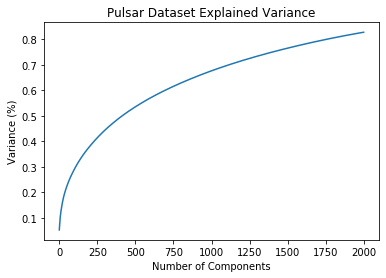

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2000, n_iter=5)
svd.fit(X_train_itemdes)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [0]:
best_n_components=2000

 2000 components preserves about 80% of the information, so we will take 5000 components in our feature set to maximise variance

In [128]:
#for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(preprocessed_train_des)
X_submission_itemdes2 = vectorizer.transform(preprocessed_test2)
print("Shape of train matrix after one hot encodig ",X_submission_itemdes2.shape)

Shape of train matrix after one hot encodig  (3460725, 5000)


## Length of Item description

In [58]:
X_train_des_wordcount = []
for i in tqdm(preprocessed_train_des):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_train_des_wordcount.append(cnt_words)

100%|████████████████████████████████████████████████████████████████████| 1186028/1186028 [00:10<00:00, 108861.29it/s]


In [59]:
df_train['Number of words in item description']= X_train_des_wordcount

In [60]:
X_test_des_wordcount = []
for i in tqdm(preprocessed_test_des):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_test_des_wordcount.append(cnt_words)

100%|███████████████████████████████████████████████████████████████████████| 296507/296507 [00:03<00:00, 97142.57it/s]


In [61]:
df_test['Number of words in item description']= X_test_des_wordcount

In [129]:
X_submission_des_wordcount = []
for i in tqdm(preprocessed_test2):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_submission_des_wordcount.append(cnt_words)

100%|████████████████████████████████████████████████████████████████████| 3460725/3460725 [00:29<00:00, 115856.61it/s]


In [130]:
test2['Number of words in item description']= X_submission_des_wordcount

In [64]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(df_train['Number of words in item description'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_words_des_norm = normalizer.transform(df_train['Number of words in item description'].values.reshape(-1,1))

X_test_words_des_norm = normalizer.transform(df_test['Number of words in item description'].values.reshape(-1,1))

print("After normalizations")
print(X_train_words_des_norm.shape, y_train.shape)

print(X_test_words_des_norm.shape, y_test.shape)

After normalizations
(1186028, 1) (1186028,)
(296507, 1) (296507,)


In [131]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(df_train['Number of words in item description'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
submission_words_des_norm2 = normalizer.transform(test2['Number of words in item description'].values.reshape(-1,1))


print("After normalizations")
print(submission_words_des_norm2.shape)

After normalizations
(3460725, 1)


## Sentiment score of an item in description

In [66]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

X_train_sentiment = []; 
for sentence in tqdm(preprocessed_train_des):
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    X_train_sentiment.append(ss)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jksing\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████| 1186028/1186028 [04:38<00:00, 4253.34it/s]


In [67]:
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in X_train_sentiment:
    
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)

In [68]:
df_train['negative']=negative
df_train['neutral']=neutral
df_train['positive']=positive
df_train['compound']=compounding


In [69]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

X_test_sentiment = []; 
for sentence in tqdm(preprocessed_test_des):
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    X_test_sentiment.append(ss)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jksing\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████| 296507/296507 [01:10<00:00, 4214.33it/s]


In [70]:
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in X_test_sentiment:
    
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)

In [71]:
df_test['negative']=negative
df_test['neutral']=neutral
df_test['positive']=positive
df_test['compound']=compounding

In [72]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['negative'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_neg_norm = normalizer.transform(df_train['negative'].values.reshape(-1,1))

X_test_neg_norm = normalizer.transform(df_test['negative'].values.reshape(-1,1))

print("After normalizations")
print(X_train_neg_norm.shape, y_train.shape)

print(X_test_neg_norm.shape, y_test.shape)

After normalizations
(1186028, 1) (1186028,)
(296507, 1) (296507,)


In [73]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['neutral'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_neu_norm = normalizer.transform(df_train['neutral'].values.reshape(-1,1))

X_test_neu_norm = normalizer.transform(df_test['neutral'].values.reshape(-1,1))

print("After normalizations")
print(X_train_neu_norm.shape, y_train.shape)

print(X_test_neu_norm.shape, y_test.shape)

After normalizations
(1186028, 1) (1186028,)
(296507, 1) (296507,)


In [74]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['positive'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_pos_norm = normalizer.transform(df_train['positive'].values.reshape(-1,1))

X_test_pos_norm = normalizer.transform(df_test['positive'].values.reshape(-1,1))

print("After normalizations")
print(X_train_pos_norm.shape, y_train.shape)

print(X_test_pos_norm.shape, y_test.shape)

After normalizations
(1186028, 1) (1186028,)
(296507, 1) (296507,)


In [75]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['compound'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_com_norm = normalizer.transform(df_train['compound'].values.reshape(-1,1))

X_test_com_norm = normalizer.transform(df_test['compound'].values.reshape(-1,1))

print("After normalizations")
print(X_train_com_norm.shape, y_train.shape)

print(X_test_com_norm.shape, y_test.shape)

After normalizations
(1186028, 1) (1186028,)
(296507, 1) (296507,)


In [132]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

submission_sentiment = []; 
for sentence in tqdm(preprocessed_test2):
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    submission_sentiment.append(ss)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jksing\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████| 3460725/3460725 [13:41<00:00, 4214.14it/s]


In [133]:
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in submission_sentiment:
    
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)

In [134]:
test2['negative']=negative
test2['neutral']=neutral
test2['positive']=positive
test2['compound']=compounding

In [135]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['negative'].values.reshape(-1,1))
sub_neg_norm2 = normalizer.transform(test2['negative'].values.reshape(-1,1))
normalizer.fit(df_train['neutral'].values.reshape(-1,1))
sub_neu_norm2 = normalizer.transform(test2['neutral'].values.reshape(-1,1))
normalizer.fit(df_train['positive'].values.reshape(-1,1))

sub_pos_norm2 = normalizer.transform(test2['positive'].values.reshape(-1,1))
normalizer.fit(df_train['compound'].values.reshape(-1,1))
#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))


sub_com_norm2 = normalizer.transform(test2['compound'].values.reshape(-1,1))



print("After normalizations")
print(sub_neg_norm2.shape)

After normalizations
(3460725, 1)


In [81]:
from scipy.sparse import csr_matrix

In [82]:
 X_dummies = csr_matrix(pd.get_dummies(df_train[['item_condition_id', 'shipping']],
                                          sparse=True).values)

In [83]:
 X_test_dummies = csr_matrix(pd.get_dummies(df_test[['item_condition_id', 'shipping']],
                                          sparse=True).values)

In [136]:
submission_dummies2 = csr_matrix(pd.get_dummies(test2[['item_condition_id', 'shipping']],
                                          sparse=True).values)

## Merging all features in a matrix

In [85]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

In [86]:
X_train = hstack((train_name,train_brandname, train_gen,train_subcat1,train_subcat2,X_train_itemdes,X_dummies,X_train_words_des_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_com_norm)).tocsr()

X_test = hstack((test_name,test_brandname,test_gen,test_subcat1,test_subcat2,X_test_itemdes,X_test_dummies,X_test_words_des_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_com_norm)).tocsr()

print("Final Data matrix")
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)
print("="*100)

Final Data matrix
(1186028, 26870) (1186028,)
(296507, 26870) (296507,)


In [137]:
submission2 = hstack((submission_name2,submission_brand_name2, submission_general_cat2,submission_subcat_12,submission_subcat_22,X_submission_itemdes2,submission_dummies2,submission_words_des_norm2,sub_neg_norm2,sub_neu_norm2,sub_pos_norm2,sub_com_norm2)).tocsr()


print("Final Data matrix")
print(submission2.shape)

Final Data matrix
(3460725, 26870)


## Ridge Regression

In [88]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
#from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
parameters = {"alpha":[0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1,10,100,1000,10000,100000]}
ridgeReg = Ridge(solver = "lsqr", fit_intercept=False)
lr_reg = GridSearchCV(ridgeReg,param_grid =parameters,n_jobs=-1)
lr_reg.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False,
                             max_iter=None, normalize=False, random_state=None,
                             solver='lsqr', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-08, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0, 1,
                                   10, 100, 1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
lr_reg.best_params_

{'alpha': 1}

In [0]:
ridgeReg = Ridge(alpha=1,solver = "lsqr", fit_intercept=False )
ridgeReg.fit(X_train, y_train)
y_pred = ridgeReg.predict(X_test)


In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
ridge_RMSLE = np.sqrt(mean_squared_error(y_test, y_pred))
print(' Fold %02d Ridge RMSLE: ', ridge_RMSLE)

 Fold %02d Ridge RMSLE:  0.488133669363245


In [138]:
ridgeReg = Ridge(alpha=1,solver = "lsqr", fit_intercept=False )
ridgeReg.fit(X_train, y_train)
predridge2 = ridgeReg.predict(submission2)

## Light GBM Regressor

In [0]:
pip install lightgbm


In [90]:
from lightgbm import LGBMRegressor

In [0]:
from lightgbm import LGBMRegressor
gridParams = {
    'learning_rate': [ 0.1,0.2,0.3,0.4,0.5],
    'n_estimators': [100,150, 200,250,300,400,500],
    'num_leaves': [20,30,63,80,100,120],
    'boosting_type' : ['gbdt'],
    'max_depth' : [2,3,4,5,6,7,8]
}
lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression'
        }
model = LGBMRegressor(**lgbm_params)
# Create the grid
grid = GridSearchCV(model, gridParams, verbose=1, cv=3, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train,
         
         early_stopping_rounds=100,
         verbose=True)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)


Fitting 3 folds for each of 1470 candidates, totalling 4410 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 115.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 267.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 411.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 647.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 851.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 1113.9min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 1418.5min
[Parallel(n_jobs=-1)]: Done 4410 out of 4410 | elapsed: 1590.6min finished


[1]	valid_0's rmse: 0.681361
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.649366
[3]	valid_0's rmse: 0.633062
[4]	valid_0's rmse: 0.618051
[5]	valid_0's rmse: 0.609167
[6]	valid_0's rmse: 0.602525
[7]	valid_0's rmse: 0.597745
[8]	valid_0's rmse: 0.593077
[9]	valid_0's rmse: 0.588714
[10]	valid_0's rmse: 0.585425
[11]	valid_0's rmse: 0.581771
[12]	valid_0's rmse: 0.578655
[13]	valid_0's rmse: 0.576088
[14]	valid_0's rmse: 0.57387
[15]	valid_0's rmse: 0.571424
[16]	valid_0's rmse: 0.56918
[17]	valid_0's rmse: 0.566815
[18]	valid_0's rmse: 0.564157
[19]	valid_0's rmse: 0.561971
[20]	valid_0's rmse: 0.560374
[21]	valid_0's rmse: 0.558008
[22]	valid_0's rmse: 0.556481
[23]	valid_0's rmse: 0.555073
[24]	valid_0's rmse: 0.553517
[25]	valid_0's rmse: 0.551777
[26]	valid_0's rmse: 0.55015
[27]	valid_0's rmse: 0.548716
[28]	valid_0's rmse: 0.547678
[29]	valid_0's rmse: 0.546301
[30]	valid_0's rmse: 0.545144
[31]	valid_0's rmse: 0.544177
[32]	valid_0's rmse:

In [0]:

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)


Best parameters found by grid search are: {'boosting_type': 'gbdt', 'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 500, 'num_leaves': 80}
Best score found by grid search is: 0.5995288112621514


In [0]:

lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression','boosting_type': 'gbdt','learning_rate': 0.5,'max_depth': 8,'n_estimators': 500,'num_leaves': 80,
      }
model = LGBMRegressor(**lgbm_params)
model.fit(X_train, y_train,
         
         
         early_stopping_rounds=100,
         verbose=True)

print('Generating submission...')

preds2 = model.predict(X_test)

[1]	valid_0's rmse: 0.681366
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.649334
[3]	valid_0's rmse: 0.633044
[4]	valid_0's rmse: 0.618043
[5]	valid_0's rmse: 0.60918
[6]	valid_0's rmse: 0.602547
[7]	valid_0's rmse: 0.59777
[8]	valid_0's rmse: 0.59308
[9]	valid_0's rmse: 0.588865
[10]	valid_0's rmse: 0.585563
[11]	valid_0's rmse: 0.582236
[12]	valid_0's rmse: 0.578915
[13]	valid_0's rmse: 0.576117
[14]	valid_0's rmse: 0.573994
[15]	valid_0's rmse: 0.571908
[16]	valid_0's rmse: 0.569244
[17]	valid_0's rmse: 0.567149
[18]	valid_0's rmse: 0.564249
[19]	valid_0's rmse: 0.561809
[20]	valid_0's rmse: 0.560012
[21]	valid_0's rmse: 0.557506
[22]	valid_0's rmse: 0.556007
[23]	valid_0's rmse: 0.554475
[24]	valid_0's rmse: 0.552394
[25]	valid_0's rmse: 0.550636
[26]	valid_0's rmse: 0.548789
[27]	valid_0's rmse: 0.547678
[28]	valid_0's rmse: 0.546431
[29]	valid_0's rmse: 0.544908
[30]	valid_0's rmse: 0.543818
[31]	valid_0's rmse: 0.54282
[32]	valid_0's rmse:

In [0]:
lgbm_RMSLE = np.sqrt(mean_squared_error(y_test, preds2))
print(' Fold %02d Ridge RMSLE: ', lgbm_RMSLE)

 Fold %02d Ridge RMSLE:  0.46908439521952755


In [139]:
lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression','boosting_type': 'gbdt','learning_rate': 0.5,'max_depth': 8,'n_estimators': 500,'num_leaves': 80
        }
model = LGBMRegressor(**lgbm_params)
model.fit(X_train, y_train,
        
         
         early_stopping_rounds=100,
         verbose=True)

print('Generating submission...')

predlgb2 = model.predict(submission2)

[1]	valid_0's rmse: 0.681361
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.649366
[3]	valid_0's rmse: 0.633062
[4]	valid_0's rmse: 0.618051
[5]	valid_0's rmse: 0.609167
[6]	valid_0's rmse: 0.602525
[7]	valid_0's rmse: 0.597745
[8]	valid_0's rmse: 0.593077
[9]	valid_0's rmse: 0.588714
[10]	valid_0's rmse: 0.585425
[11]	valid_0's rmse: 0.581771
[12]	valid_0's rmse: 0.578655
[13]	valid_0's rmse: 0.576088
[14]	valid_0's rmse: 0.57387
[15]	valid_0's rmse: 0.571424
[16]	valid_0's rmse: 0.56918
[17]	valid_0's rmse: 0.566815
[18]	valid_0's rmse: 0.564157
[19]	valid_0's rmse: 0.561971
[20]	valid_0's rmse: 0.560374
[21]	valid_0's rmse: 0.558008
[22]	valid_0's rmse: 0.556481
[23]	valid_0's rmse: 0.555073
[24]	valid_0's rmse: 0.553517
[25]	valid_0's rmse: 0.551777
[26]	valid_0's rmse: 0.55015
[27]	valid_0's rmse: 0.548716
[28]	valid_0's rmse: 0.547678
[29]	valid_0's rmse: 0.546301
[30]	valid_0's rmse: 0.545144
[31]	valid_0's rmse: 0.544177
[32]	valid_0's rmse:

## SGD Regressor

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, Ridge

In [0]:

parameters = {"alpha":[0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1,10,100,1000,10000,100000],
             "l1_ratio" : [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
             }
model = SGDRegressor(
                         loss='squared_loss',
                     learning_rate='invscaling',
                         max_iter=200,
                         penalty='l2',
                         fit_intercept=False
                         )
lr_reg = GridSearchCV(model,param_grid =parameters,n_jobs=-1)
lr_reg.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=False,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=200,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-08, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0, 1,
                                   10, 100, 1000, 10000, 100000],
                         'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},

In [0]:
lr_reg.best_params_

{'alpha': 0, 'l1_ratio': 0.6}

In [0]:
model = SGDRegressor(penalty='l2',
                         loss='squared_loss',
                     learning_rate='invscaling',
                         max_iter=200,
                         
                         fit_intercept=False,
                     alpha=0,
                     l1_ratio=0.6
                         )
model.fit(X_train, y_train)

SGDRegressor(alpha=0, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.6,
             learning_rate='invscaling', loss='squared_loss', max_iter=200,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
sgd_scores_val = model.predict(X_test)
sgd_RMSLE = np.sqrt(mean_squared_error(y_test, sgd_scores_val))
print(sgd_RMSLE)
  
   

0.499634944813034


In [140]:
model = SGDRegressor(penalty='l2',
                         loss='squared_loss',
                     learning_rate='invscaling',
                         max_iter=200,
                         
                         fit_intercept=False,
                     alpha=0,
                     l1_ratio=0.6
                         )
model.fit(X_train, y_train)
predsgd2 = model.predict(submission2)

## Random Forest Regressor

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [0]:

param_dist = {'n_estimators': [10,50,100,150,160,200,300,350,400,500],
               'min_samples_split': [2,3,5,6,7,8],
               
              
              "max_depth":[None,10,20,40,60,80,100,120]
             
              }
regr1 = RandomForestRegressor()
n_iter_search = 100
regr1 = RandomizedSearchCV(regr1, param_distributions=param_dist,
                                     n_jobs=-1, n_iter=n_iter_search, cv=3)

regr1.fit(X_train, y_train)

In [98]:
m = RandomForestRegressor(n_jobs=-1,min_samples_split=3,n_estimators=200,max_depth=40)
m.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [100]:
predr = m.predict(X_test)
rf_RMSLE = np.sqrt(mean_squared_error(y_test, predr))
print(rf_RMSLE)
  

0.49960919554257155


In [141]:
predran2 = m.predict(submission2)

## Ensemble

In [142]:
predsub2 = (predlgb2 * 0.4 + predran2 * 0.2 + predridge2 * 0.3 +predsgd2 *0.1)

## We are doing ensemble modelling on all the 4 algorithms that we have used to calculate regression and gave weights to each of the final values as per the RMSLE of the algorithm.

In [144]:
submission_final['price'] = np.expm1(predsub2)
submission_final.to_csv("submission_price2.csv", index=False)

In [145]:
df=pd.read_csv('submission_price2.csv')

## This is our final submission file that we created and submitted on Kaggle and got the reported accuracy.

In [147]:
df.shape

(3460725, 2)

In [148]:
df.tail(5)

,test_id,price
3460720,3460720,7.731625
3460721,3460721,23.879428
3460722,3460722,15.214789
3460723,3460723,17.486868
3460724,3460724,21.054176


## Conclusion

In [61]:

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "HyperParameters used",  "RMSLE"]

x.add_row(["Ridge Regression", "alpha", 0.48])
x.add_row(["Light GBM", "learning_rate,n_estimators,boosting_type,num_leaves,max_depth",  0.46])
x.add_row(["SGD Regressor","alpha,l1_ratio" , 0.49])
x.add_row(["Random Forest Regressor ","n_estimators,min_samples_split,max_depth" ,  0.496])






print(x)

+--------------------------+---------------------------------------------------------------+-------+
|          Model           |                      HyperParameters used                     | RMSLE |
+--------------------------+---------------------------------------------------------------+-------+
|     Ridge Regression     |                             alpha                             |  0.48 |
|        Light GBM         | learning_rate,n_estimators,boosting_type,num_leaves,max_depth |  0.46 |
|      SGD Regressor       |                         alpha,l1_ratio                        |  0.49 |
| Random Forest Regressor  |            n_estimators,min_samples_split,max_depth           | 0.496 |
+--------------------------+---------------------------------------------------------------+-------+


## Summary

- The Dataset is imported from Kaggle and basic data analysis is done for all the features to extract useful information.
- We did feature engineering and incorporated two additional features 'Length of item description' and 'Sentiment score' that influence price of an item fairly.
- We studied the correlation between different features 
- We did necessary preprocessing on the text features, one-hot encoding for the categorical features and tf-idf vectorisation for text features.
- Finally, hstacked all the features in a matrix and prepared it to feed into the algorithms.
- This is a regression problem and we have used 'Ridge Regression', 'Light GBM', 'SGD regressor' and 'Random Forest regressor' for our models.

- "RMSLE" was the error metric specified for this challenge, so all our algorithms calculted RMSLE as the error metric
- Hyperparameters were tuned for each of the models and the best parameters were used to predict prices on the test dataset.
- As it can be seen from the pretty table, LightGBM gives the best results and hence we gave maximum weightage to it while calcutaing the final predicted price of an item in ensemble modelling.
- After using ensembling modelling, we brought down the RMSLE score and it was reported to be 0.45 in the competition score and it performs better than each of the algorithms when applied indidivually.
- So, ensemble modelling gives the best performance for our challenge
